# Élaboration d’un modèle Content-Based Filtering

🔹 Chargement des embeddings des articles...
⚠️ Embeddings chargé sous forme de numpy.ndarray ! Transformation en dictionnaire requise.
✅ Embeddings chargés - Nombre d'articles: 364047
🔹 Exemples d'articles dans les embeddings: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
🔹 Recherche du nombre optimal de dimensions PCA...


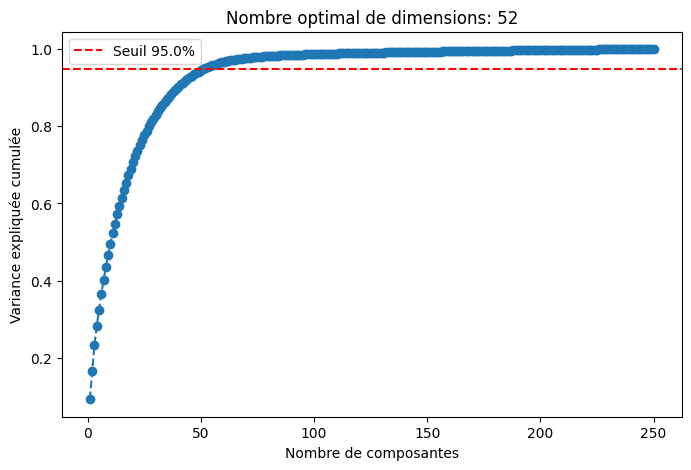

✅ Nombre optimal de dimensions pour capturer 95% de variance: 52
🔹 Chargement des données...
🔹 Chargement des interactions utilisateur-article...
✅ Interactions chargées - Nombre de lignes: 2988181
🔹 Chargement des métadonnées des articles...
✅ Métadonnées chargées - Nombre d'articles: 364047
🔹 Chargement des embeddings des articles...
⚠️ Embeddings chargé sous forme de numpy.ndarray ! Transformation en dictionnaire requise.
✅ Embeddings chargés - Nombre d'articles: 364047
🔹 Exemples d'articles dans les embeddings: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
🔹 Réduction de dimension des embeddings...
✅ Réduction terminée.
🔹 Exécution de la recommandation pour l'utilisateur 115523...
🔹 Recherche d'un article existant cliqué par l'utilisateur 115523...
🔹 Vérification des articles cliqués présents dans les embeddings...
🔹 Articles cliqués par l'utilisateur: [65991, 285675, 289090, 336220, 235616, 277491, 87236, 87231, 87224, 87231, 87228, 157844, 198144, 285808, 166581]
🔹 Articles disponibles dans les

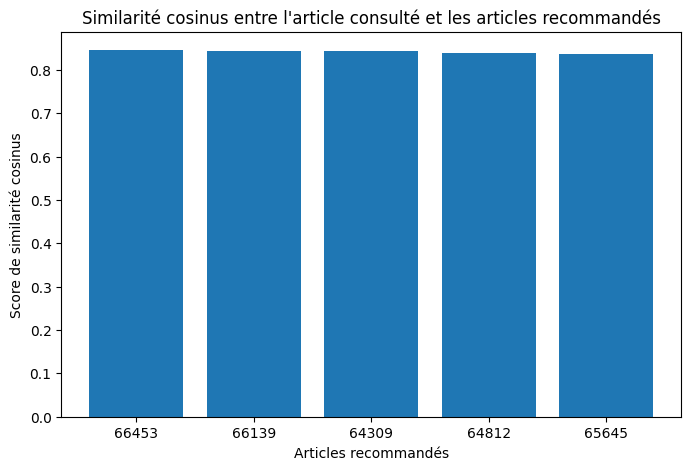

🔹 Fin


In [31]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

# 📌 Chemins des fichiers
PATH = "/code/dataset/"
CLICKS_FOLDER = PATH + "clicks/"
ARTICLES_METADATA_PATH = PATH + "articles_metadata.csv"
EMBEDDINGS_PATH = PATH + "articles_embeddings.pickle"

# 📌 Charger les interactions utilisateur-article
def load_interactions():
    print("🔹 Chargement des interactions utilisateur-article...")
    all_files = [os.path.join(CLICKS_FOLDER, f) for f in os.listdir(CLICKS_FOLDER) if f.startswith("clicks_hour_") and f.endswith(".csv")]
    df_list = [pd.read_csv(f) for f in all_files]
    interactions_df = pd.concat(df_list, ignore_index=True)
    interactions_df.rename(columns={"click_article_id": "article_id"}, inplace=True)
    interactions_df["article_id"] = interactions_df["article_id"].astype(int)  # S'assurer que ce sont des entiers
    print("✅ Interactions chargées - Nombre de lignes:", interactions_df.shape[0])
    return interactions_df

# 📌 Charger les métadonnées des articles
def load_articles_metadata():
    print("🔹 Chargement des métadonnées des articles...")
    df = pd.read_csv(ARTICLES_METADATA_PATH)
    df["article_id"] = df["article_id"].astype(int)  # Assurer cohérence des types
    print("✅ Métadonnées chargées - Nombre d'articles:", df.shape[0])
    return df

# 📌 Charger les embeddings des articles
def load_articles_embeddings():
    print("🔹 Chargement des embeddings des articles...")
    with open(EMBEDDINGS_PATH, "rb") as f:
        embeddings = pickle.load(f)
    
    # Vérification du type des embeddings
    if isinstance(embeddings, np.ndarray):
        print("⚠️ Embeddings chargé sous forme de numpy.ndarray ! Transformation en dictionnaire requise.")
        embeddings = {i: embeddings[i] for i in range(len(embeddings))}  # Création d'un dict fictif
    
    print("✅ Embeddings chargés - Nombre d'articles:", len(embeddings))
    print("🔹 Exemples d'articles dans les embeddings:", list(embeddings.keys())[:10])
    return embeddings

# 📌 Réduction de dimension optimale avec PCA
def find_optimal_pca_dim(embeddings, variance_threshold=0.95):
    print("🔹 Recherche du nombre optimal de dimensions PCA...")
    
    # Conversion des embeddings en matrice numpy
    article_vectors = np.array(list(embeddings.values()))
    
    # Appliquer PCA sans réduction pour voir la variance expliquée
    pca = PCA()
    pca.fit(article_vectors)
    
    # Calcul de la variance expliquée cumulée
    variance_explained = np.cumsum(pca.explained_variance_ratio_)
    
    # Trouver le k optimal (premier k atteignant le seuil)
    k_optimal = np.argmax(variance_explained >= variance_threshold) + 1
    
    # Affichage du Scree Plot
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(variance_explained) + 1), variance_explained, marker='o', linestyle='--')
    plt.axhline(y=variance_threshold, color='r', linestyle='--', label=f'Seuil {variance_threshold*100}%')
    plt.xlabel('Nombre de composantes')
    plt.ylabel('Variance expliquée cumulée')
    plt.title(f'Nombre optimal de dimensions: {k_optimal}')
    plt.legend()
    plt.show()

    return k_optimal

# Charger les embeddings
embeddings = load_articles_embeddings()

# Trouver le nombre optimal de dimensions
k_optimal = find_optimal_pca_dim(embeddings)

# Affichage du résultat
print(f"✅ Nombre optimal de dimensions pour capturer 95% de variance: {k_optimal}")

# 📌 Vérifier si un article existe dans les embeddings
def find_existing_article(user_articles, embeddings):
    print("🔹 Vérification des articles cliqués présents dans les embeddings...")
    print("🔹 Articles cliqués par l'utilisateur:", user_articles)
    print("🔹 Articles disponibles dans les embeddings:", list(embeddings.keys())[:10])
    
    for article in user_articles:
        if article in embeddings:
            return article
    return None

# 📌 Construire un profil utilisateur basé sur un article existant
def get_last_existing_article(user_id, interactions_df, embeddings):
    print(f"🔹 Recherche d'un article existant cliqué par l'utilisateur {user_id}...")
    user_clicks = interactions_df[interactions_df["user_id"] == user_id]
    if user_clicks.empty:
        print("⚠️ Aucun historique de clics trouvé pour cet utilisateur.")
        return None
    
    user_articles = user_clicks.sort_values(by="click_timestamp", ascending=False)["article_id"].tolist()
    valid_article = find_existing_article(user_articles, embeddings)
    if valid_article is None:
        print("⚠️ Aucun article cliqué ne figure dans les embeddings.")
    else:
        print(f"✅ Article utilisé pour la recommandation: {valid_article}")
    return valid_article

# 📌 Recommander des articles basés sur la similarité cosinus
def recommend_articles(user_id, interactions_df, embeddings, top_n=5):
    last_article_id = get_last_existing_article(user_id, interactions_df, embeddings)
    if last_article_id is None:
        return []

    last_article_vector = embeddings[last_article_id].reshape(1, -1)
    article_ids = list(embeddings.keys())
    article_vectors = np.array([embeddings[a] for a in article_ids])

    print("🔹 Calcul de la similarité cosinus...")
    similarities = cosine_similarity(last_article_vector, article_vectors)[0]
    recommended_indices = similarities.argsort()[::-1]  # Tri décroissant

    # Exclure l'article déjà consulté
    recommended_articles = [article_ids[i] for i in recommended_indices if article_ids[i] != last_article_id][:top_n]

    print(f"✅ Articles recommandés pour l'utilisateur {user_id}: {recommended_articles}")

    # 📌 Affichage du graphique de similarité cosinus
    plt.figure(figsize=(8, 5))
    plt.bar(range(len(recommended_articles)), similarities[[article_ids.index(a) for a in recommended_articles]], tick_label=recommended_articles)
    plt.xlabel("Articles recommandés")
    plt.ylabel("Score de similarité cosinus")
    plt.title("Similarité cosinus entre l'article consulté et les articles recommandés")
    plt.show()

    return recommended_articles

# 📌 Réduction de dimension des embeddings si nécessaire
def reduce_embeddings_dimensionality(embeddings, n_components=k_optimal):
    print("🔹 Réduction de dimension des embeddings...")
    article_vectors = np.array(list(embeddings.values()))
    pca = PCA(n_components=n_components)
    reduced_vectors = pca.fit_transform(article_vectors)
    reduced_embeddings = {k: v for k, v in zip(embeddings.keys(), reduced_vectors)}
    print("✅ Réduction terminée.")
    return reduced_embeddings

# 📌 Exécution du modèle
print("🔹 Chargement des données...")
interactions_df = load_interactions()
articles_metadata = load_articles_metadata()
embeddings = load_articles_embeddings()

# Réduction de dimension si nécessaire
if isinstance(embeddings, dict) and len(next(iter(embeddings.values()))) > k_optimal:
    embeddings = reduce_embeddings_dimensionality(embeddings)

# 📌 Tester la recommandation sur un utilisateur donné
example_user = interactions_df["user_id"].iloc[0]
print(f"🔹 Exécution de la recommandation pour l'utilisateur {example_user}...")
recommended_articles = recommend_articles(example_user, interactions_df, embeddings)
print("🔹 Fin")


# Élaboration d’un modèle de type Collaborative Filtering

In [ ]:
import os
import pandas as pd
import numpy as np
import pickle
import logging
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

# 📌 Chemins des fichiers
PATH = "/code/dataset/"
CLICKS_FOLDER = PATH + "clicks/"
ARTICLES_METADATA_PATH = PATH + "articles_metadata.csv"
EMBEDDINGS_PATH = PATH + "articles_embeddings.pickle"
MODEL_PATH = PATH + "recommender_model.pkl"

# 📌 Charger les interactions utilisateur-article
def load_interactions():
    print("🔹 Chargement des interactions utilisateur-article...")
    all_files = [os.path.join(CLICKS_FOLDER, f) for f in os.listdir(CLICKS_FOLDER) if f.startswith("clicks_hour_") and f.endswith(".csv")]
    df_list = [pd.read_csv(f) for f in all_files]
    interactions_df = pd.concat(df_list, ignore_index=True)
    interactions_df.rename(columns={"click_article_id": "article_id"}, inplace=True)
    interactions_df["article_id"] = interactions_df["article_id"].astype(int)
    print("✅ Interactions chargées - Nombre de lignes:", interactions_df.shape[0])
    return interactions_df

# 📌 Charger les embeddings des articles
def load_articles_embeddings():
    print("🔹 Chargement des embeddings des articles...")
    with open(EMBEDDINGS_PATH, "rb") as f:
        embeddings = pickle.load(f)
    
    if isinstance(embeddings, np.ndarray):
        print("⚠️ Embeddings chargé sous forme de numpy.ndarray ! Transformation en dictionnaire requise.")
        embeddings = {i: embeddings[i] for i in range(len(embeddings))}
    
    print("✅ Embeddings chargés - Nombre d'articles:", len(embeddings))
    print("🔹 Exemples d'articles dans les embeddings:", list(embeddings.keys())[:10])
    return embeddings

# 📌 Réduction de dimension des embeddings si nécessaire
def reduce_embeddings_dimensionality(embeddings, n_components=50):
    print("🔹 Réduction de dimension des embeddings...")
    article_vectors = np.array(list(embeddings.values()))
    pca = PCA(n_components=n_components)
    reduced_vectors = pca.fit_transform(article_vectors)
    reduced_embeddings = {k: v for k, v in zip(embeddings.keys(), reduced_vectors)}
    print("✅ Réduction terminée.")
    return reduced_embeddings

# 📌 Entraîner le modèle de filtrage collaboratif
def train_collaborative_model(interactions_df):
    print("🔹 Préparation des données pour Surprise...")
    reader = Reader(rating_scale=(1, 5))
    surprise_data = Dataset.load_from_df(interactions_df[["user_id", "article_id", "session_size"]], reader)
    
    print("🔹 Entraînement du modèle SVD...")
    trainset, testset = train_test_split(surprise_data, test_size=0.2)
    model = SVD()
    model.fit(trainset)
    
    print(f"✅ Sauvegarde du modèle dans {MODEL_PATH}...")
    with open(MODEL_PATH, "wb") as f:
        pickle.dump(model, f)
    
    print("🚀 Modèle entraîné et sauvegardé avec succès !")
    return model

# 📌 Recommander des articles avec filtrage collaboratif
def recommend_articles_cf(user_id, interactions_df, model, top_n=5):
    known_articles = interactions_df[interactions_df["user_id"] == user_id]["article_id"].unique()
    all_articles = interactions_df["article_id"].unique()
    unknown_articles = np.setdiff1d(all_articles, known_articles)
    
    predictions = [(article, model.predict(user_id, article).est) for article in unknown_articles]
    predictions.sort(key=lambda x: x[1], reverse=True)
    recommended_articles = [article for article, _ in predictions[:top_n]]
    
    print(f"✅ Articles recommandés pour l'utilisateur {user_id} (Collaborative Filtering) : {recommended_articles}")
    return recommended_articles

# 📌 Comparer Content-Based et Collaborative Filtering
def compare_recommendations(user_id, interactions_df, embeddings, model, top_n=5):
    print(f"🔹 Comparaison des recommandations pour l'utilisateur {user_id}...")
    
    # Filtrage basé sur le contenu
    last_article_id = interactions_df[interactions_df["user_id"] == user_id].sort_values(by="click_timestamp", ascending=False)["article_id"].iloc[0]
    last_article_vector = embeddings[last_article_id].reshape(1, -1)
    article_ids = list(embeddings.keys())
    article_vectors = np.array([embeddings[a] for a in article_ids])
    similarities = cosine_similarity(last_article_vector, article_vectors)[0]
    recommended_content = [article_ids[i] for i in np.argsort(similarities)[::-1] if article_ids[i] != last_article_id][:top_n]
    
    # Filtrage collaboratif
    recommended_cf = recommend_articles_cf(user_id, interactions_df, model, top_n)
    
    print(f"🔹 Content-Based : {recommended_content}")
    print(f"🔹 Collaborative Filtering : {recommended_cf}")
    
    return recommended_content, recommended_cf

# 📌 Exécution
interactions_df = load_interactions()
embeddings = load_articles_embeddings()
if isinstance(embeddings, dict) and len(next(iter(embeddings.values()))) > 50:
    embeddings = reduce_embeddings_dimensionality(embeddings)
model = train_collaborative_model(interactions_df)
example_user = interactions_df["user_id"].iloc[0]
compare_recommendations(example_user, interactions_df, embeddings, model)
print("🔹 Fin")

# Hybride

In [23]:
import os
import pandas as pd
import numpy as np
import pickle
import logging
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# 📌 Chemins des fichiers
PATH = "/code/dataset/"
CLICKS_FOLDER = PATH + "clicks/"
ARTICLES_METADATA_PATH = PATH + "articles_metadata.csv"
EMBEDDINGS_PATH = PATH + "articles_embeddings.pickle"
MODEL_PATH = PATH + "recommender_model_hybrid.pkl"


# 📌 Charger les interactions utilisateur-article
def load_interactions():
    print("🔹 Chargement des interactions utilisateur-article...")
    all_files = [os.path.join(CLICKS_FOLDER, f) for f in os.listdir(CLICKS_FOLDER) if f.startswith("clicks_hour_") and f.endswith(".csv")]
    df_list = [pd.read_csv(f) for f in all_files]
    interactions_df = pd.concat(df_list, ignore_index=True)
    interactions_df.rename(columns={"click_article_id": "article_id"}, inplace=True)
    interactions_df["article_id"] = interactions_df["article_id"].astype(int)
    print("✅ Interactions chargées - Nombre de lignes:", interactions_df.shape[0])
    return interactions_df

# 📌 Charger les embeddings des articles
def load_articles_embeddings():
    print("🔹 Chargement des embeddings des articles...")
    with open(EMBEDDINGS_PATH, "rb") as f:
        embeddings = pickle.load(f)
    
    if isinstance(embeddings, np.ndarray):
        print("⚠️ Embeddings chargé sous forme de numpy.ndarray ! Transformation en dictionnaire requise.")
        embeddings = {i: embeddings[i] for i in range(len(embeddings))}
    
    print("✅ Embeddings chargés - Nombre d'articles:", len(embeddings))
    print("🔹 Exemples d'articles dans les embeddings:", list(embeddings.keys())[:10])
    return embeddings

# 📌 Entraîner le modèle de filtrage collaboratif
def train_collaborative_model(interactions_df):
    print("🔹 Préparation des données pour Surprise...")
    reader = Reader(rating_scale=(1, 5))
    surprise_data = Dataset.load_from_df(interactions_df[["user_id", "article_id", "session_size"]], reader)
    
    print("🔹 Entraînement du modèle SVD...")
    trainset, testset = train_test_split(surprise_data, test_size=0.2)
    model = SVD()
    model.fit(trainset)
    
    print(f"✅ Sauvegarde du modèle dans {MODEL_PATH}...")
    with open(MODEL_PATH, "wb") as f:
        pickle.dump(model, f)
    
    print("🚀 Modèle entraîné et sauvegardé avec succès !")
    return model

# 📌 Recommander des articles avec méthode hybride
def hybrid_recommendation(user_id, interactions_df, embeddings, model, top_n=5, alpha=0.5):
    known_articles = interactions_df[interactions_df["user_id"] == user_id]["article_id"].unique()
    all_articles = interactions_df["article_id"].unique()
    unknown_articles = np.setdiff1d(all_articles, known_articles)
    
    user_clicks = interactions_df[interactions_df["user_id"] == user_id].sort_values(by="click_timestamp", ascending=False)
    if user_clicks.empty:
        print("⚠️ Aucun historique de clics trouvé pour cet utilisateur. Utilisation du filtrage basé sur le contenu uniquement.")
        alpha = 1  
    
    # Filtrage collaboratif
    cf_scores = {article: model.predict(user_id, article).est for article in unknown_articles}
    
    if cf_scores:
        cf_values = np.array(list(cf_scores.values())).reshape(-1, 1)
        cf_values = MinMaxScaler().fit_transform(cf_values).flatten()
        cf_scores = {article: score for article, score in zip(cf_scores.keys(), cf_values)}
        print(f"🔹 Top 10 articles recommandés par CF : {sorted(cf_scores, key=cf_scores.get, reverse=True)[:10]}")
    else:
        print("⚠️ Aucune recommandation CF disponible.")
    
    # Filtrage basé sur le contenu
    last_article_id = user_clicks["article_id"].iloc[0] if not user_clicks.empty else None
    content_scores = {}
    if last_article_id and last_article_id in embeddings:
        last_article_vector = embeddings[last_article_id].reshape(1, -1)
        article_ids = list(embeddings.keys())
        article_vectors = np.array([embeddings[a] for a in article_ids])
        similarities = cosine_similarity(last_article_vector, article_vectors)[0]
        content_scores = {article_ids[i]: similarities[i] for i in range(len(article_ids))}
    
    if content_scores:
        content_values = np.array(list(content_scores.values())).reshape(-1, 1)
        content_values = MinMaxScaler().fit_transform(content_values).flatten()
        content_scores = {article: score for article, score in zip(content_scores.keys(), content_values)}
    
    # Sélection proportionnelle des recommandations CF et CBF
    num_cf = int(alpha * top_n)
    num_cb = top_n - num_cf
    
    top_cf = sorted(cf_scores, key=cf_scores.get, reverse=True)[:num_cf]
    top_cb = sorted(content_scores, key=content_scores.get, reverse=True)[:num_cb]
    
    recommended_articles = list(dict.fromkeys(top_cf + top_cb))[:top_n]  # Supprimer les doublons
    
    print(f"✅ Articles recommandés pour l'utilisateur {user_id} (Hybride) : {recommended_articles}")
    return recommended_articles

# 📌 Exécution
interactions_df = load_interactions()
embeddings = load_articles_embeddings()
model = train_collaborative_model(interactions_df)
example_user = interactions_df["user_id"].iloc[0]
hybrid_recommendation(example_user, interactions_df, embeddings, model)
print("🔹 Fin")

🔹 Chargement des interactions utilisateur-article...
✅ Interactions chargées - Nombre de lignes: 2988181
🔹 Chargement des embeddings des articles...
⚠️ Embeddings chargé sous forme de numpy.ndarray ! Transformation en dictionnaire requise.
✅ Embeddings chargés - Nombre d'articles: 364047
🔹 Exemples d'articles dans les embeddings: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
🔹 Préparation des données pour Surprise...
🔹 Entraînement du modèle SVD...
✅ Sauvegarde du modèle dans /code/dataset/recommender_model_hybrid.pkl...
🚀 Modèle entraîné et sauvegardé avec succès !
🔹 Top 10 articles recommandés par CF : [3885, 4899, 8030, 9649, 15775, 16780, 29730, 31697, 36349, 43079]
✅ Articles recommandés pour l'utilisateur 115523 (Hybride) : [3885, 4899, 65991, 64812, 64309]
🔹 Fin


# Implicit

In [26]:
import os
import pandas as pd
import numpy as np
import pickle
import logging
import scipy.sparse as sparse
import implicit
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from scipy.sparse import coo_matrix
import json

# 📌 Chemins des fichiers
PATH = "/code/dataset/"
CLICKS_FOLDER = PATH + "clicks/"
ARTICLES_METADATA_PATH = PATH + "articles_metadata.csv"
EMBEDDINGS_PATH = PATH + "articles_embeddings.pickle"
MODEL_PATH = PATH + "recommender_model_implicit.pkl"

# 📌 Charger les interactions utilisateur-article
def load_interactions():
    print("🔹 Chargement des interactions utilisateur-article...")
    all_files = [os.path.join(CLICKS_FOLDER, f) for f in os.listdir(CLICKS_FOLDER) if f.startswith("clicks_hour_") and f.endswith(".csv")]
    df_list = [pd.read_csv(f) for f in all_files]
    interactions_df = pd.concat(df_list, ignore_index=True)
    interactions_df.rename(columns={"click_article_id": "article_id"}, inplace=True)
    interactions_df["article_id"] = interactions_df["article_id"].astype(int)
    interactions_df["user_id"] = interactions_df["user_id"].astype(int)
    print("✅ Interactions chargées - Nombre de lignes:", interactions_df.shape[0])
    return interactions_df

# 📌 Charger les embeddings des articles
def load_articles_embeddings():
    print("🔹 Chargement des embeddings des articles...")
    with open(EMBEDDINGS_PATH, "rb") as f:
        embeddings = pickle.load(f)
    
    if isinstance(embeddings, np.ndarray):
        print("⚠️ Embeddings chargé sous forme de numpy.ndarray ! Transformation en dictionnaire requise.")
        embeddings = {i: embeddings[i] for i in range(len(embeddings))}
    
    print("✅ Embeddings chargés - Nombre d'articles:", len(embeddings))
    return embeddings

# 📌 Construire la matrice utilisateur-article sous format sparse
def build_user_item_matrix(interactions_df):
    print("🔹 Construction de la matrice utilisateur-article en format sparse...")
    
    user_ids = interactions_df["user_id"].astype("category")
    item_ids = interactions_df["article_id"].astype("category")

    # Création d'une matrice COO (Coordinate format) pour éviter les matrices denses
    user_item_sparse = coo_matrix(
        (np.ones(len(interactions_df)), 
         (user_ids.cat.codes, item_ids.cat.codes))
    )

    print(f"✅ Matrice utilisateur-article créée : {user_item_sparse.shape[0]} utilisateurs, {user_item_sparse.shape[1]} articles.")
    
    return user_item_sparse.tocsr(), user_ids, item_ids

# 📌 Entraîner le modèle Implicit ALS
def train_implicit_model(user_item_matrix):
    print("🔹 Entraînement du modèle ALS...")
    model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20)
    model.fit(user_item_matrix)
    
    print(f"✅ Sauvegarde du modèle dans {MODEL_PATH}...")
    with open(MODEL_PATH, "wb") as f:
        pickle.dump(model, f)
    
    print("🚀 Modèle ALS entraîné et sauvegardé avec succès !")
    return model

# 📌 Recommander des articles avec ALS
def recommend_articles_als(user_id, model, user_item_matrix, user_ids, item_ids, top_n=5):
    # ✅ Vérifier si l'utilisateur existe dans la liste
    if user_id not in user_ids.to_numpy():
        return {"statusCode": 404, "body": json.dumps({"error": f"Utilisateur {user_id} inconnu"})}

    # ✅ Vérifier si user_id est bien dans les catégories (évite l'erreur de conversion)
    if user_id not in user_ids.cat.categories:
        return {"statusCode": 404, "body": json.dumps({"error": f"Utilisateur {user_id} absent des catégories"})}

    # ✅ Trouver l’index utilisateur correct
    user_index = user_ids[user_ids == user_id].index[0]
    user_index = user_ids.cat.codes[user_index]

    # ✅ Vérifier que cet index est bien dans la matrice utilisateur-article
    if user_index >= user_item_matrix.shape[0]:
        return {"statusCode": 404, "body": json.dumps({"error": f"Utilisateur {user_id} hors de la plage d'indexation"})}

    # ✅ Vérifier si l'utilisateur a des interactions (évite des recommandations par défaut)
    if user_item_matrix[user_index].nnz == 0:
        return {"statusCode": 404, "body": json.dumps({"error": f"L'utilisateur {user_id} n'a aucune interaction"})}

    # ✅ Récupérer les interactions de l'utilisateur
    user_items = user_item_matrix[user_index]

    # ✅ Générer les recommandations avec ALS
    recommendations = model.recommend(user_index, user_items, N=5)

    # ✅ Convertir les indices des articles en `article_id`
    recommended_articles = [int(item_ids.cat.categories[i]) for i in recommendations[0]]

    return recommended_articles


# 📌 Comparer Content-Based et Collaborative Filtering
def compare_recommendations(user_id, interactions_df, embeddings, model, user_item_matrix, item_ids, top_n=5):
    print(f"🔹 Comparaison des recommandations pour l'utilisateur {user_id}...")

    last_article_id = interactions_df[interactions_df["user_id"] == user_id].sort_values(by="click_timestamp", ascending=False)["article_id"].iloc[0]
    last_article_vector = embeddings[last_article_id].reshape(1, -1)
    
    article_ids = np.array(list(embeddings.keys()))
    article_vectors = np.array([embeddings[a] for a in article_ids])
    
    similarities = cosine_similarity(last_article_vector, article_vectors)[0]
    
    # Vérification et conversion des types
    print(f"🔍 Type de similarities : {type(similarities)}")
    print(f"🔍 Type de top_n : {type(top_n)}")
    
    if isinstance(similarities, pd.Series):
        similarities = similarities.to_numpy()
    
    if isinstance(top_n, pd.Series):  # Correction ici
        top_n = top_n.iloc[0]  # Extraire la valeur si c'est une Series
    
    if not isinstance(top_n, int):
        top_n = int(top_n)

    sorted_indices = np.argsort(similarities)[::-1]  # Trie les articles du plus similaire au moins similaire
    recommended_content = [article_ids[i] for i in sorted_indices if article_ids[i] != last_article_id][:5]



    recommended_cf = recommend_articles_als(user_id, model, user_item_matrix, user_ids, item_ids, top_n)

    print(f"🔹 Content-Based : {recommended_content}")
    print(f"🔹 Collaborative Filtering (ALS) : {recommended_cf}")

    return recommended_content, recommended_cf


# 📌 Exécution
interactions_df = load_interactions()
embeddings = load_articles_embeddings()
user_item_matrix, user_ids, item_ids = build_user_item_matrix(interactions_df)
model = train_implicit_model(user_item_matrix)
example_user = user_ids.to_numpy()[0]
print(f"📊 Nombre total d'utilisateurs: {interactions_df['user_id'].nunique()}")
print(f"📊 Nombre total d'articles: {interactions_df['article_id'].nunique()}")
print(f"📊 Exemple d'utilisateur pour test: {example_user}")

compare_recommendations(example_user, interactions_df, embeddings, model, user_item_matrix, user_ids, item_ids)


print("🔹 Fin")


🔹 Chargement des interactions utilisateur-article...
✅ Interactions chargées - Nombre de lignes: 2988181
🔹 Chargement des embeddings des articles...
⚠️ Embeddings chargé sous forme de numpy.ndarray ! Transformation en dictionnaire requise.
✅ Embeddings chargés - Nombre d'articles: 364047
🔹 Construction de la matrice utilisateur-article en format sparse...
✅ Matrice utilisateur-article créée : 322897 utilisateurs, 46033 articles.
🔹 Entraînement du modèle ALS...


  0%|          | 0/20 [00:00<?, ?it/s]

✅ Sauvegarde du modèle dans /code/dataset/recommender_model_implicit.pkl...
🚀 Modèle ALS entraîné et sauvegardé avec succès !
📊 Nombre total d'utilisateurs: 322897
📊 Nombre total d'articles: 46033
📊 Exemple d'utilisateur pour test: 115523
🔹 Comparaison des recommandations pour l'utilisateur 115523...
🔍 Type de similarities : <class 'numpy.ndarray'>
🔍 Type de top_n : <class 'pandas.core.series.Series'>
🔹 Content-Based : [64812, 64309, 66453, 209171, 66139]
🔹 Collaborative Filtering (ALS) : [31059, 30903, 17836, 21988, 31061]
🔹 Fin


In [ ]:
example_user = 115523
# \"recommendations\": [218028, 209236, 87224, 284463, 160474]}",
print(f"📊 Exemple d'utilisateur pour test: {example_user}")
compare_recommendations(example_user, interactions_df, embeddings, model, user_item_matrix, user_ids, item_ids)

print("🔹 Fin")

📊 Exemple d'utilisateur pour test: 115523
🔹 Comparaison des recommandations pour l'utilisateur 115523...
🔍 Type de similarities : <class 'numpy.ndarray'>
🔍 Type de top_n : <class 'pandas.core.series.Series'>
🔹 Content-Based : [66453, 66139, 64309, 64812, 65645]
🔹 Collaborative Filtering (ALS) : [31059, 30903, 17836, 21988, 31061]
🔹 Fin


# Annexes
## Différentes approches testées